In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import seaborn as sns
from dataloader import DataLoader
from PIL import Image
from _graphutils import GraphUtils
from _plotutils import PlotUtils
from kernels.wlkernel import WLKernel
from kernels.shortestpathkernel import ShortestPathKernel
from kernels.randomwalkkernel import RandomWalkKernel
from kernels.labelhasher import LabelHasher
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import LeaveOneOut

In [3]:
dl = DataLoader("../eyelink_data")
imgs = dl.get_annotated_images()

PLOT = {
    "aois": False,
    "scanpaths": False,
    "clustering": False,
    "matrices": False,
    "graphs": False,
    "kernel": True,
    "tsne": True,
    "mds": True
}

/home/simontitk/.pyenv/versions/gaze3p-env/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/home/simontitk/.pyenv/versions/gaze3p-env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/simontitk/.pyenv/versions/gaze3p-env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/simontitk/.pyenv/versions/gaze3p-env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/simontitk/.pyenv/versions/gaze3p-env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual 

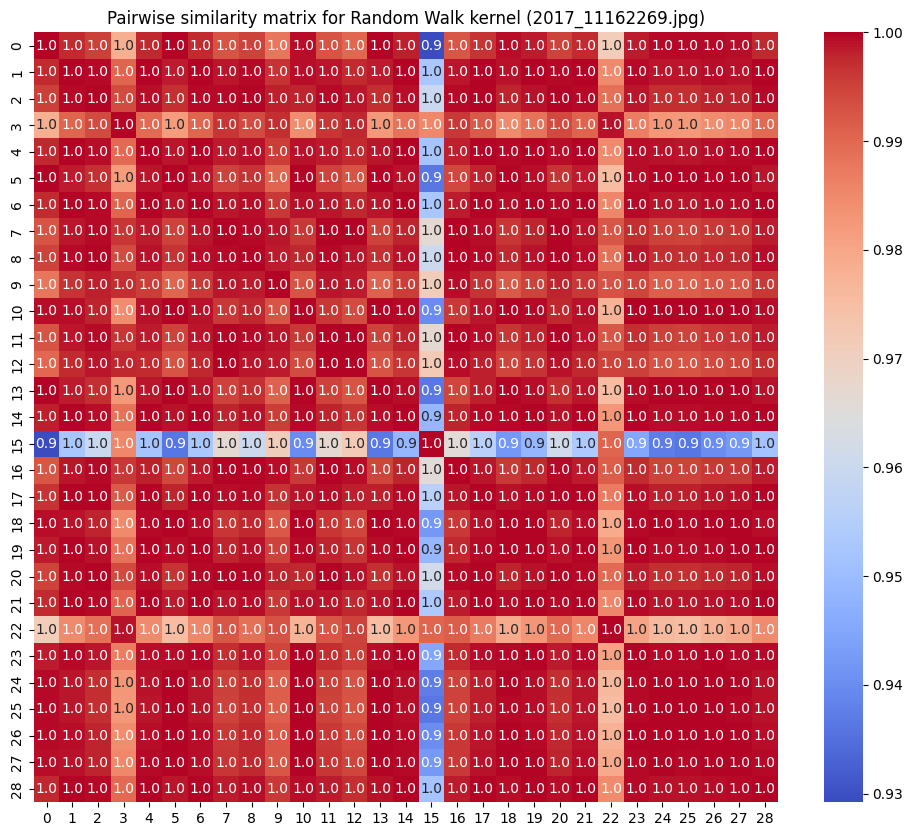

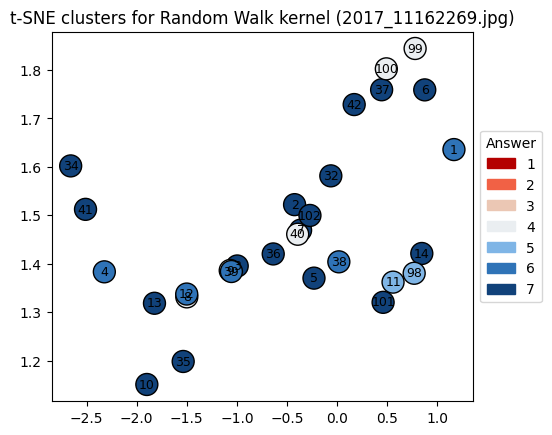

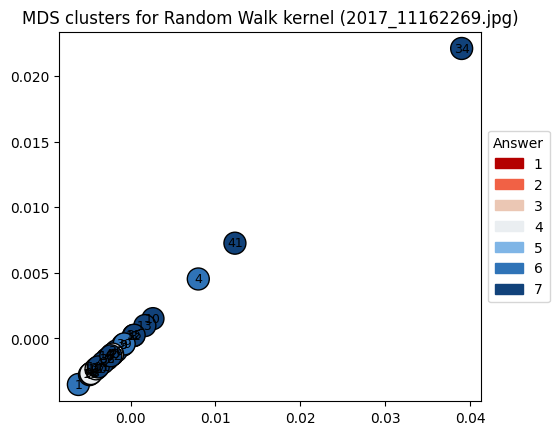

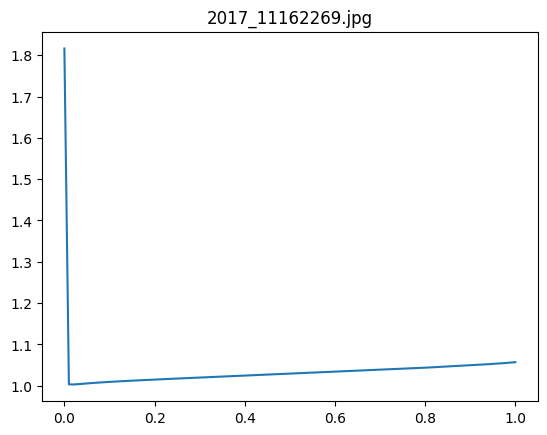

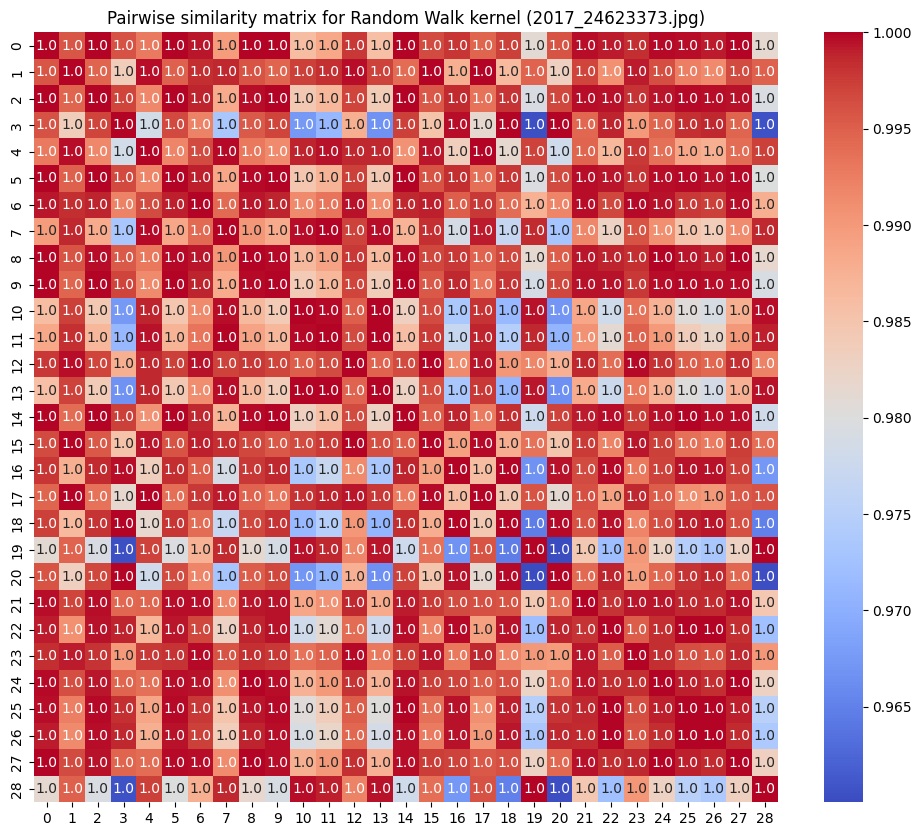

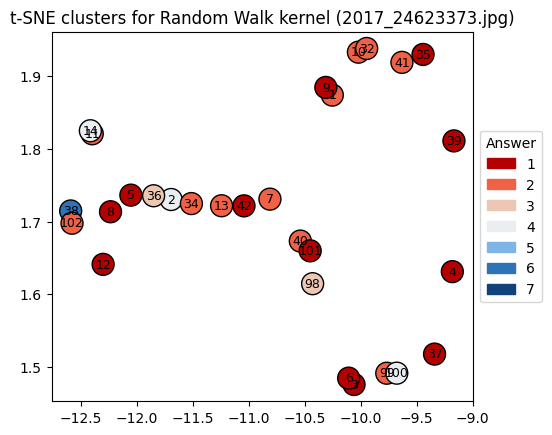

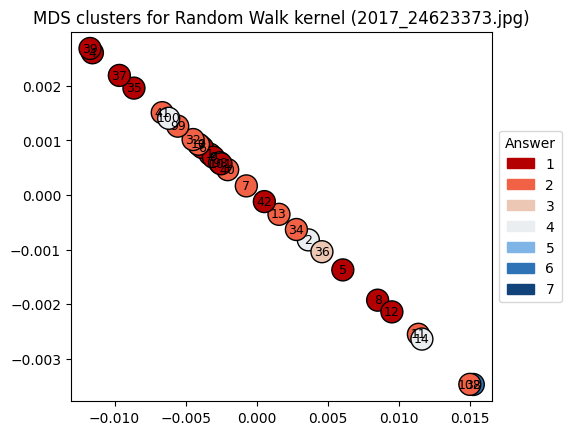

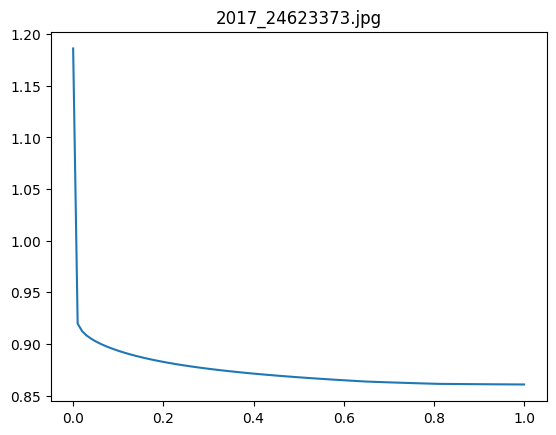

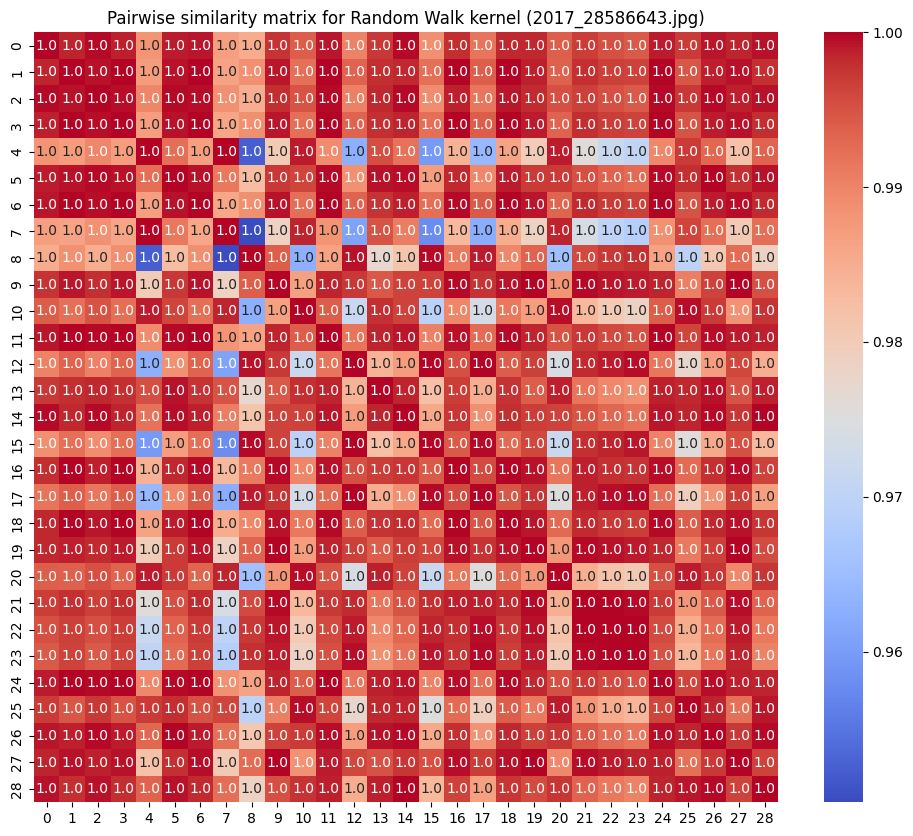

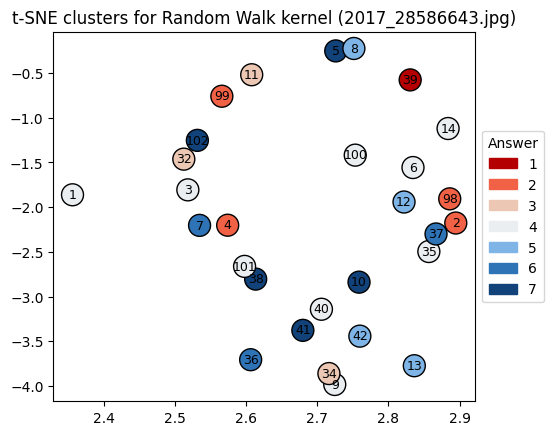

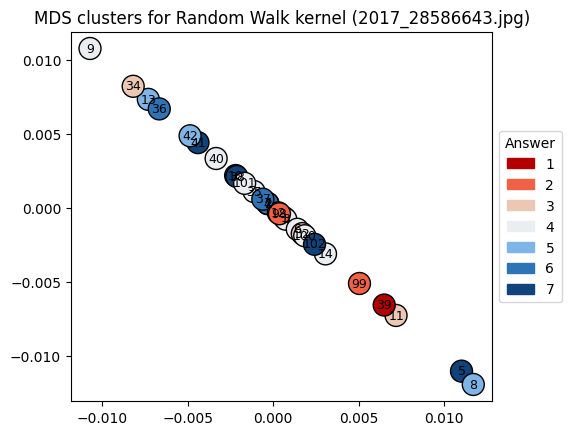

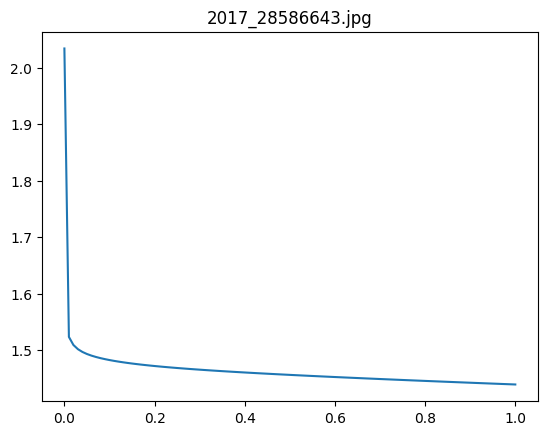

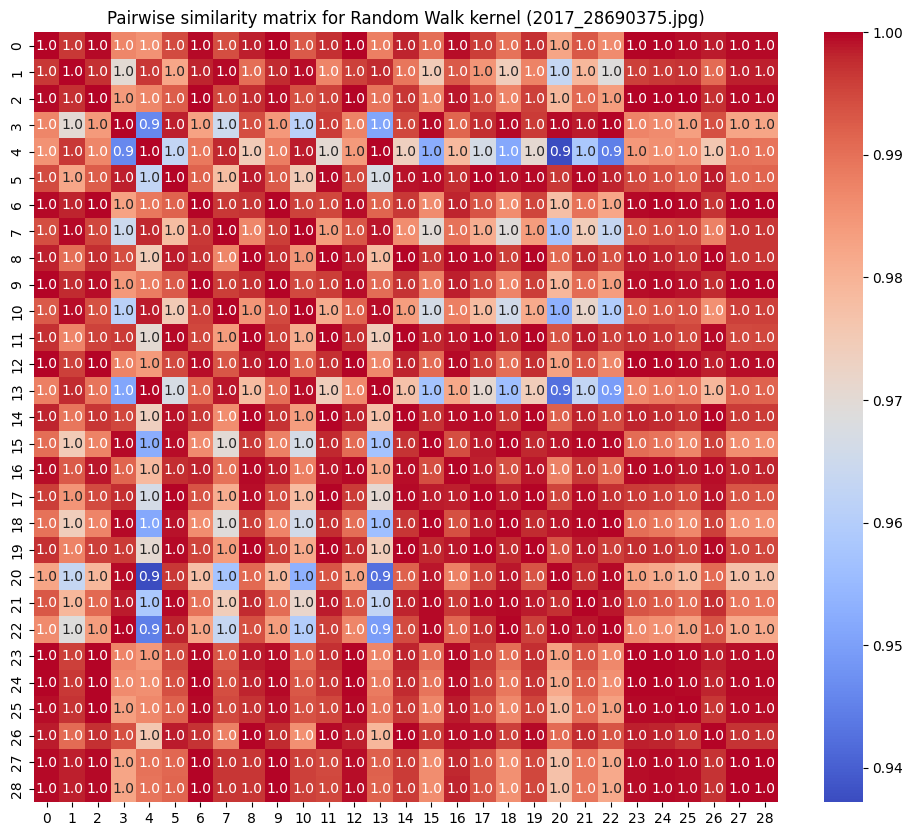

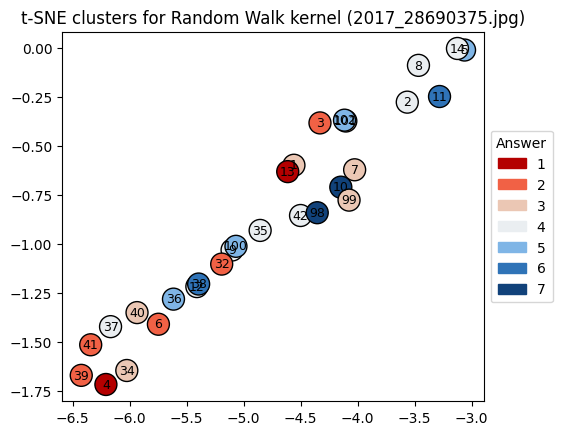

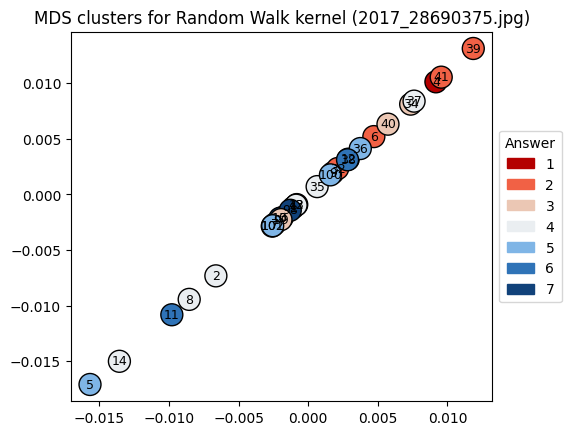

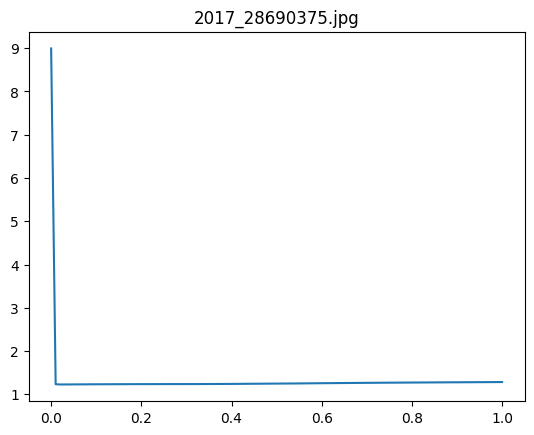

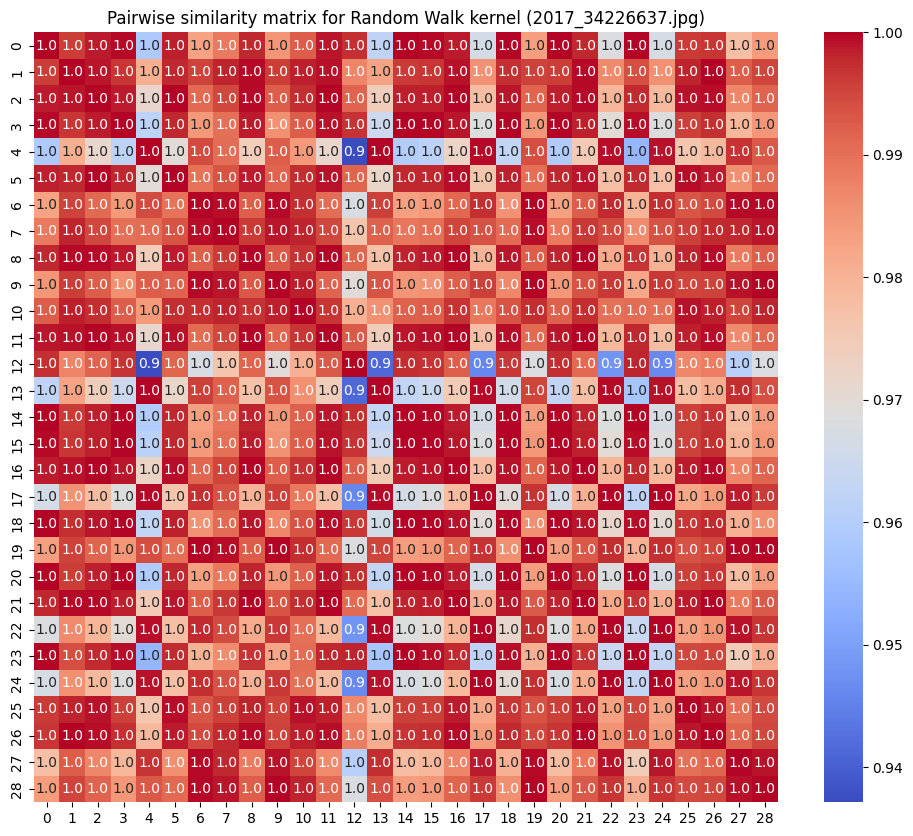

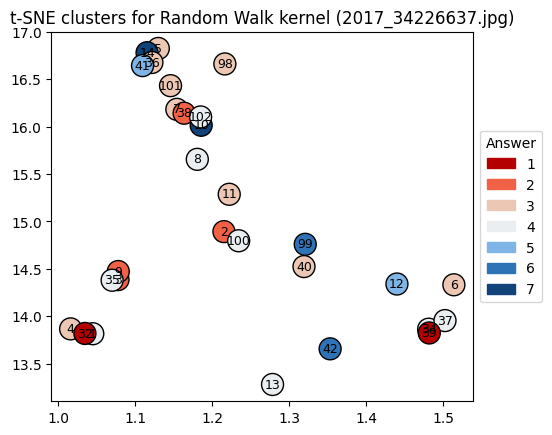

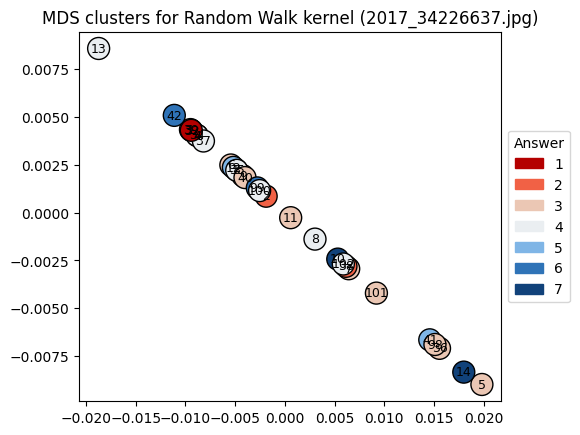

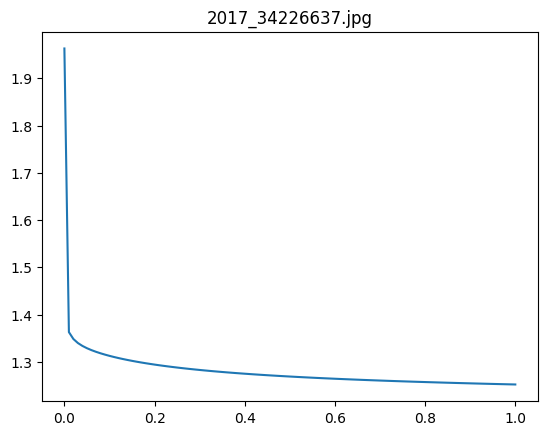

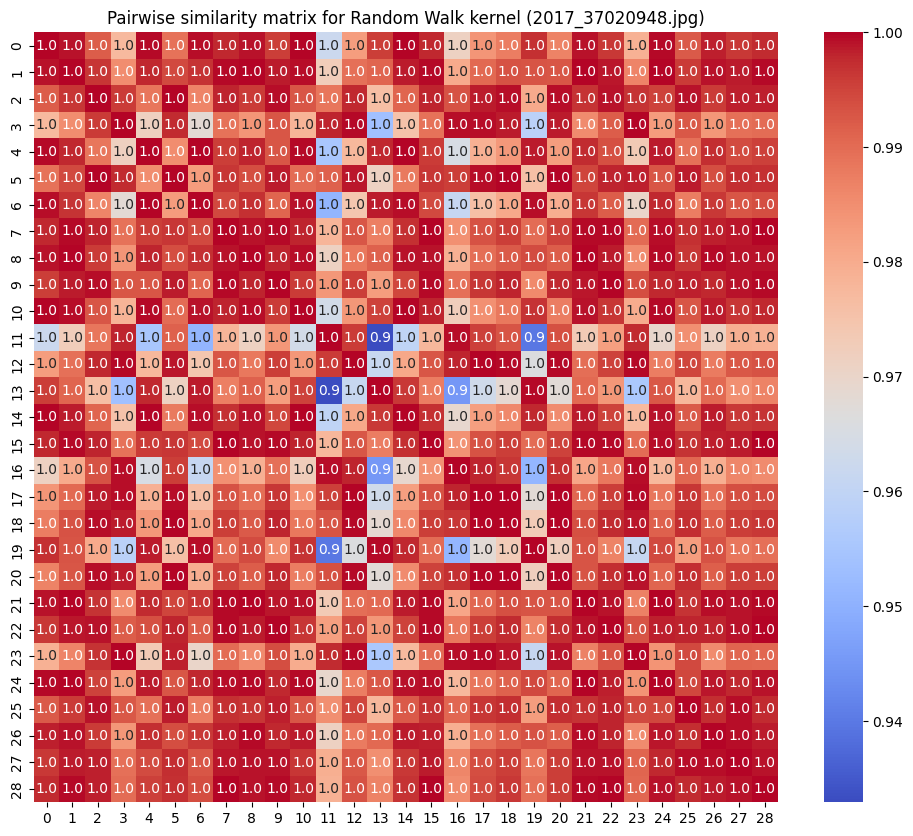

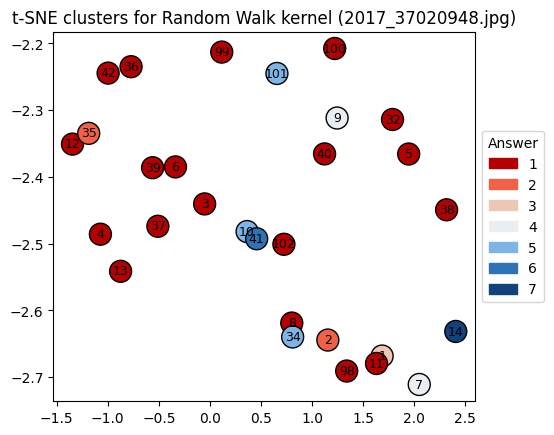

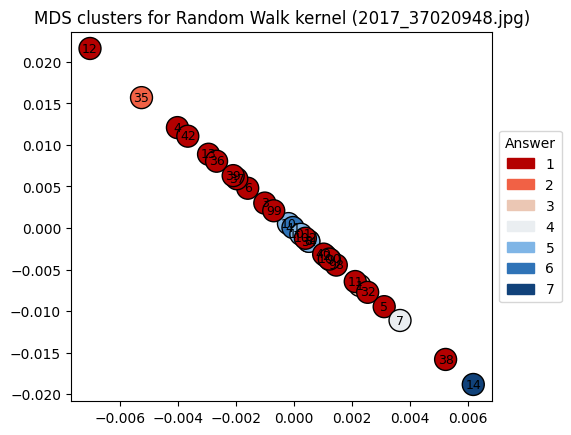

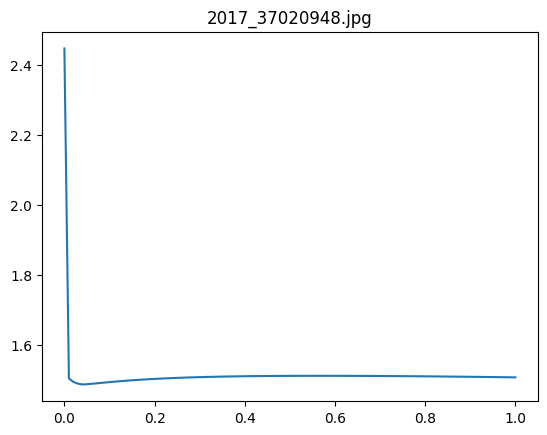

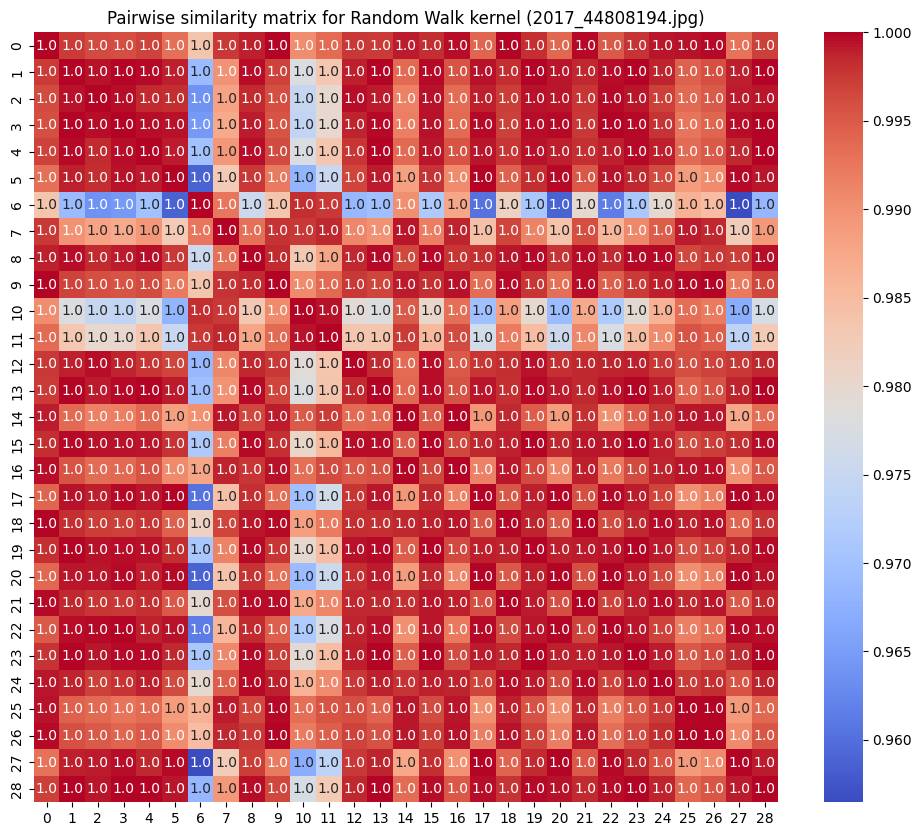

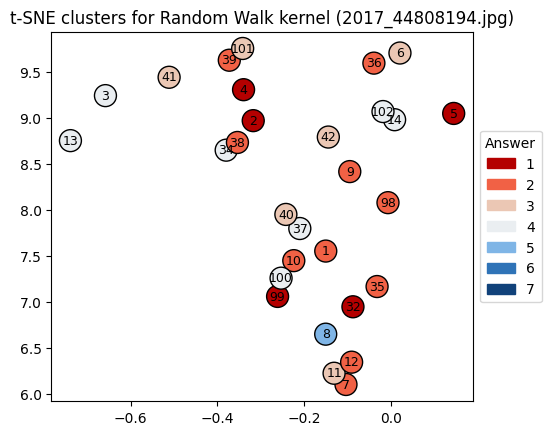

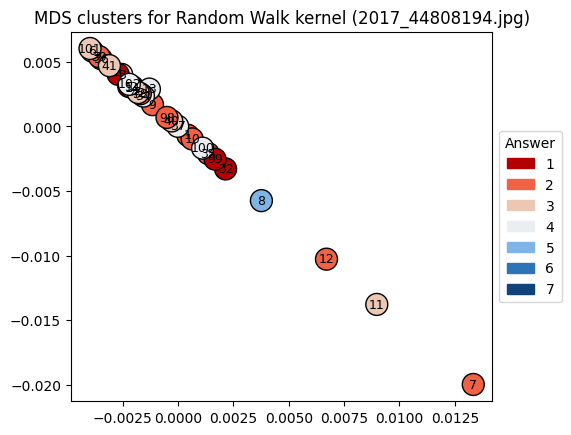

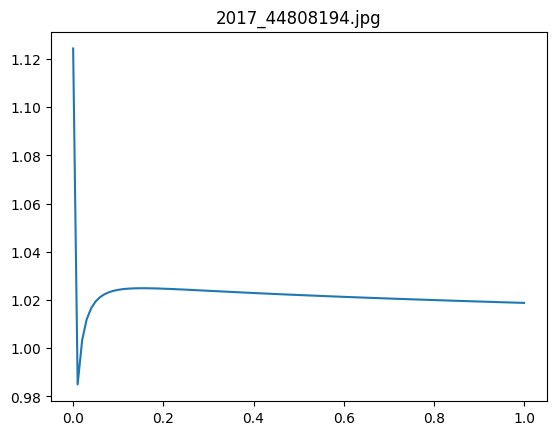

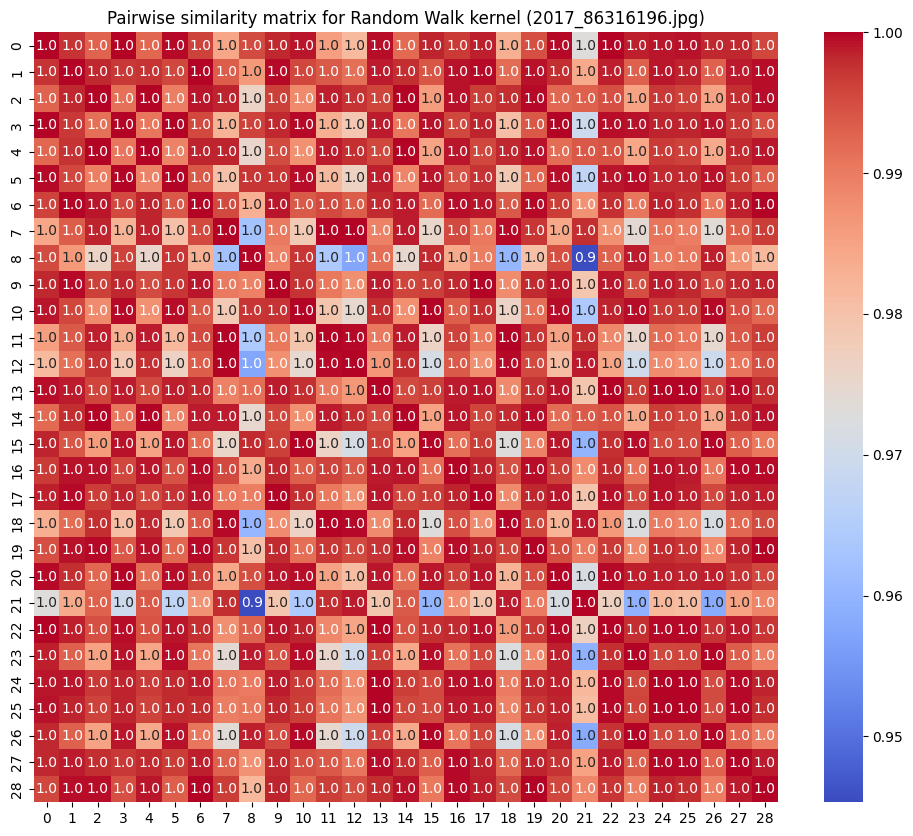

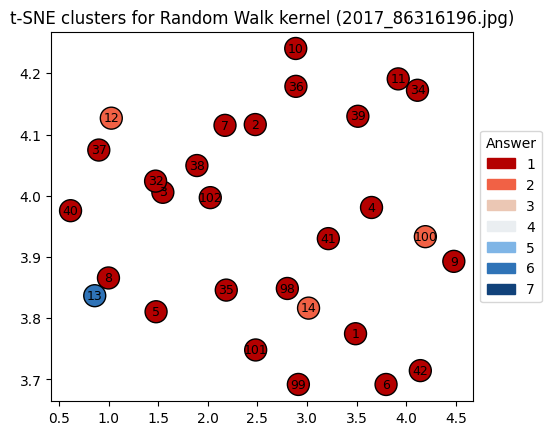

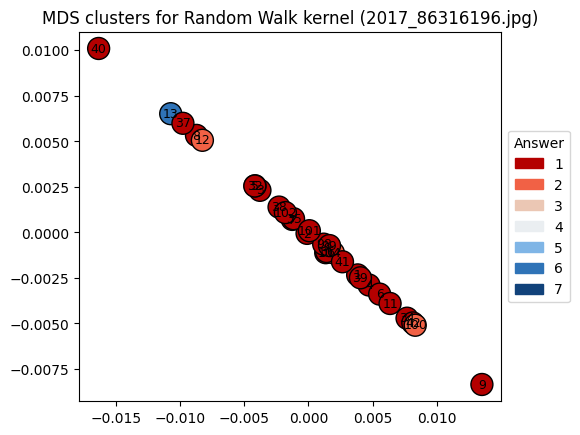

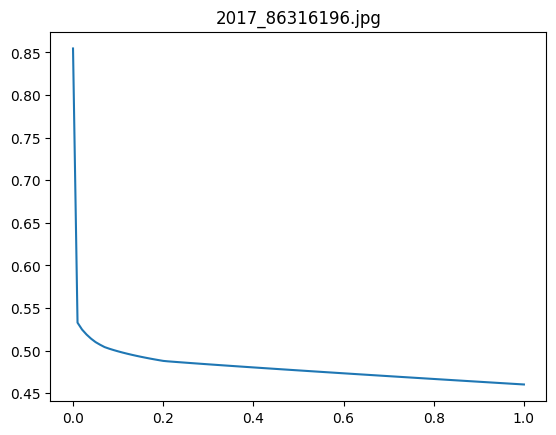

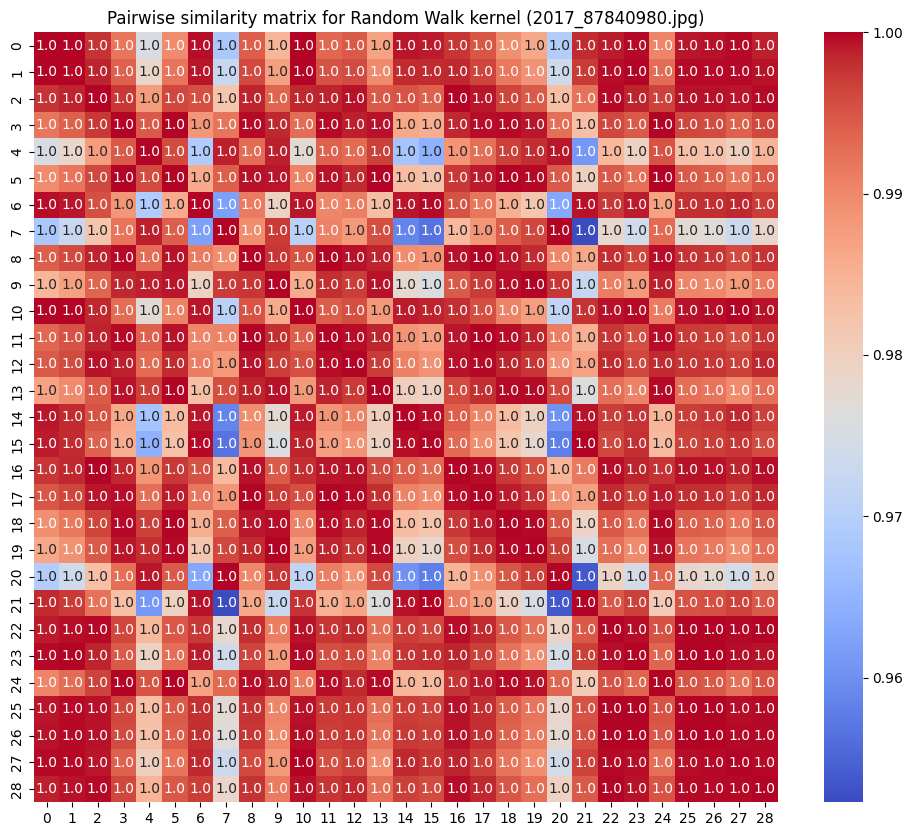

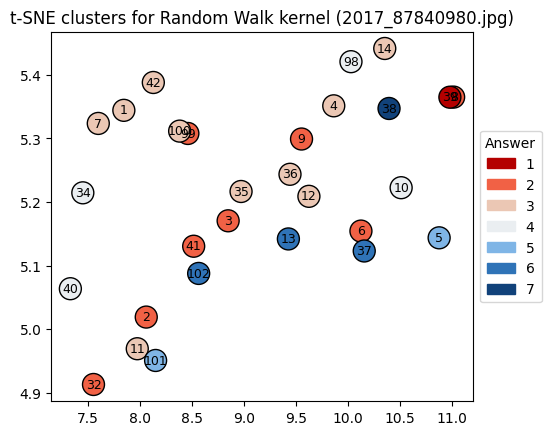

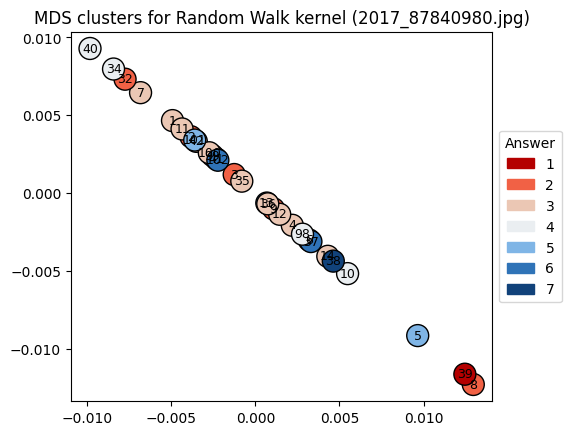

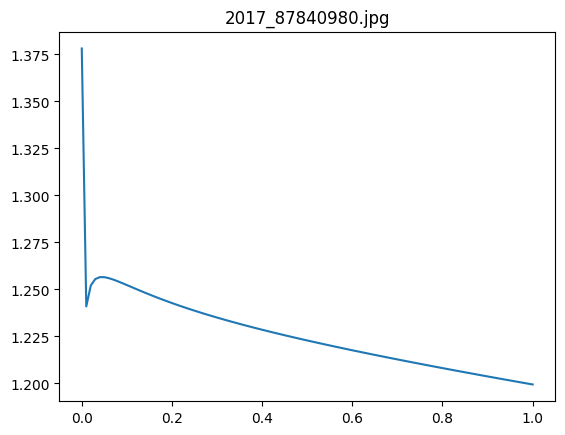

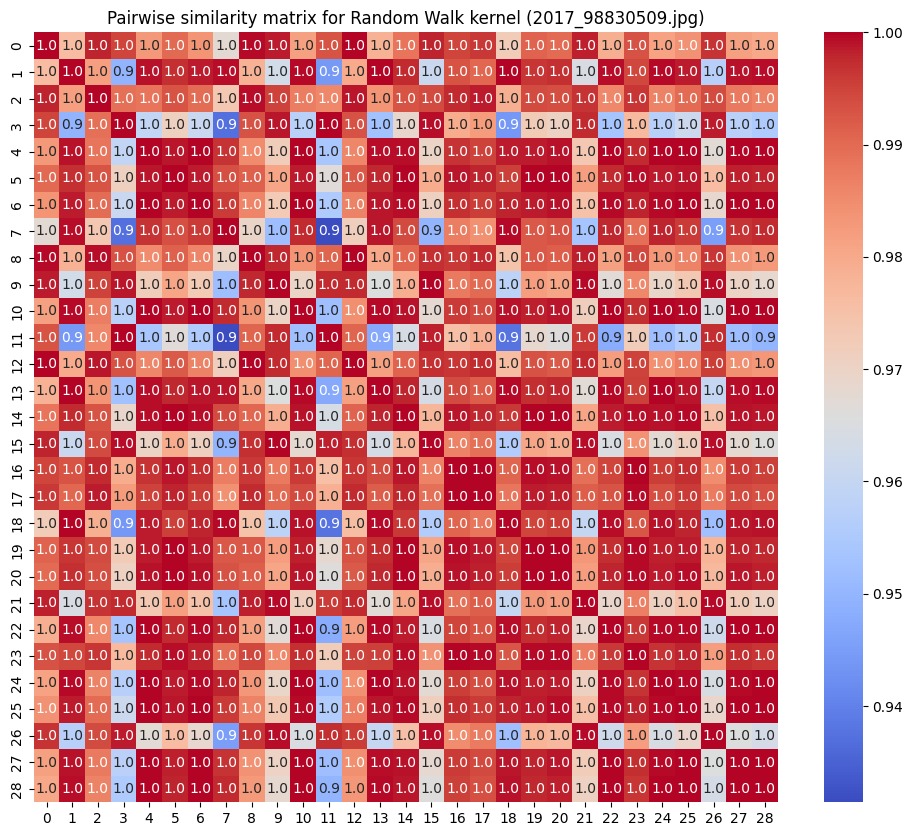

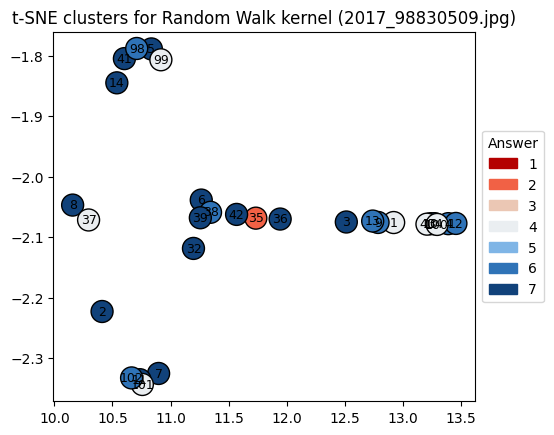

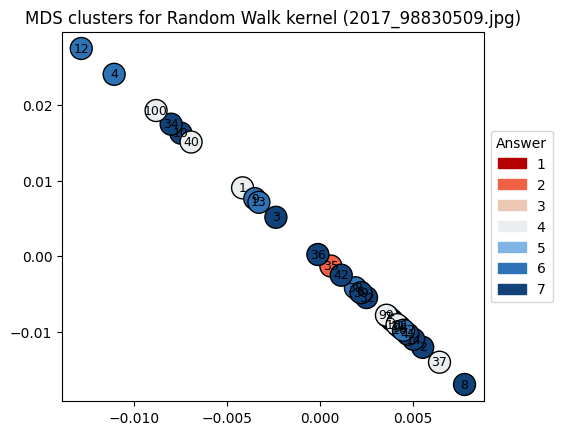

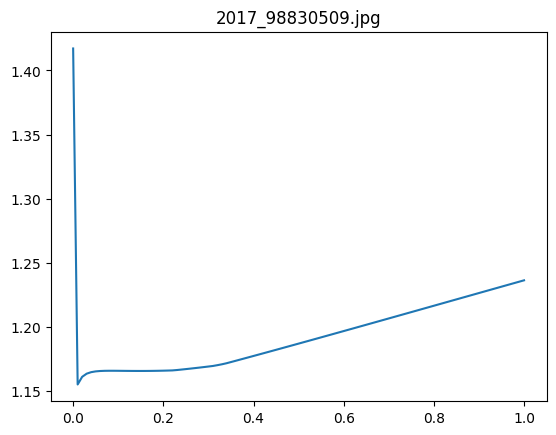

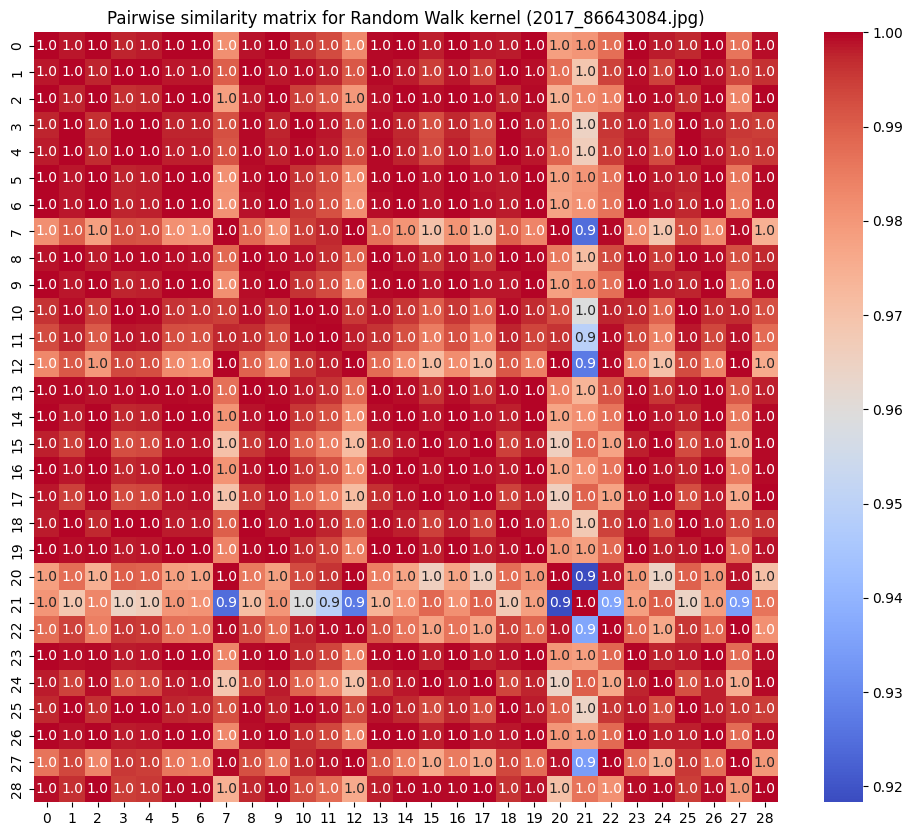

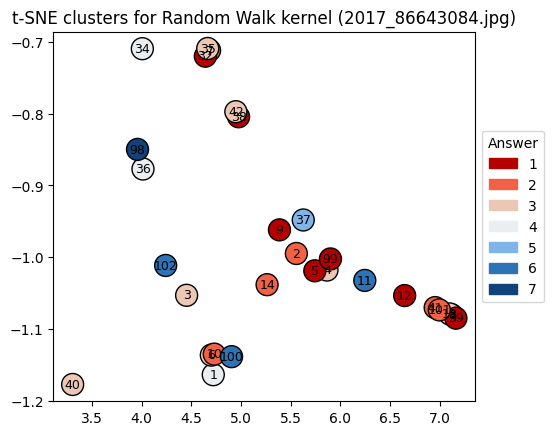

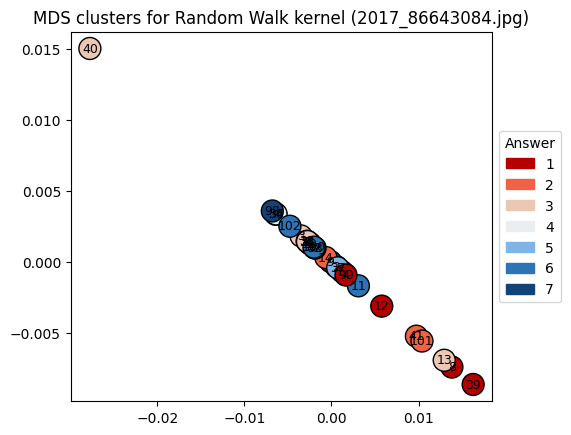

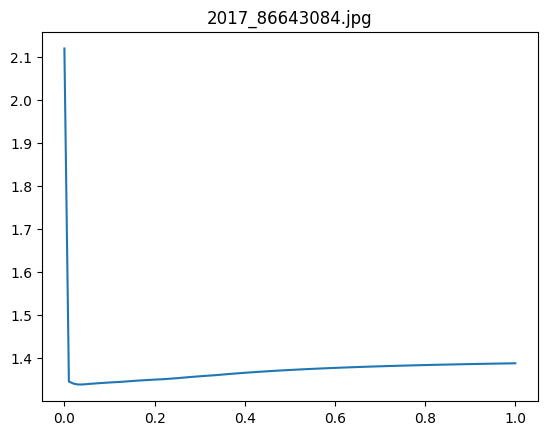

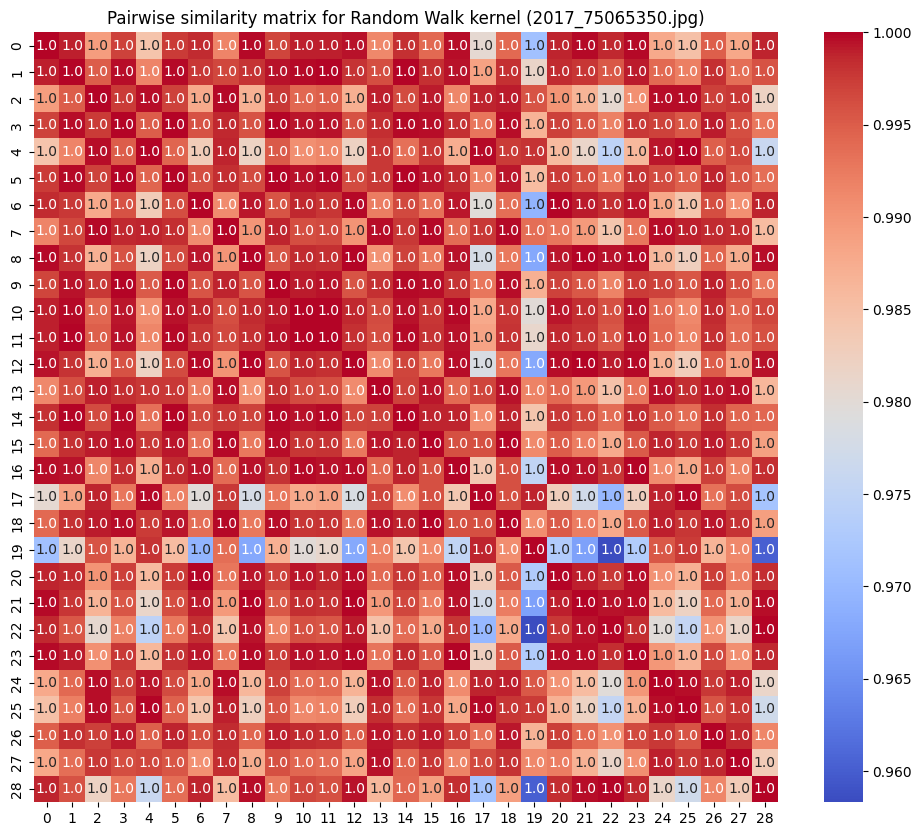

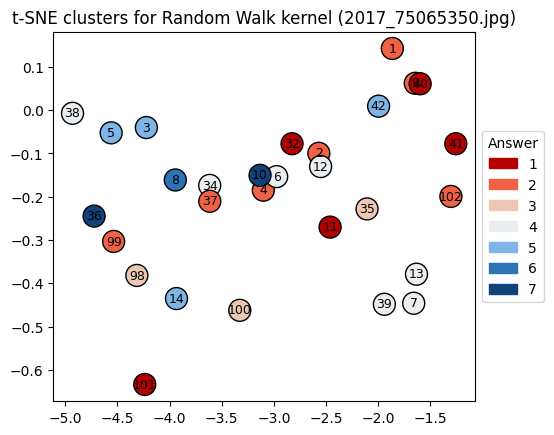

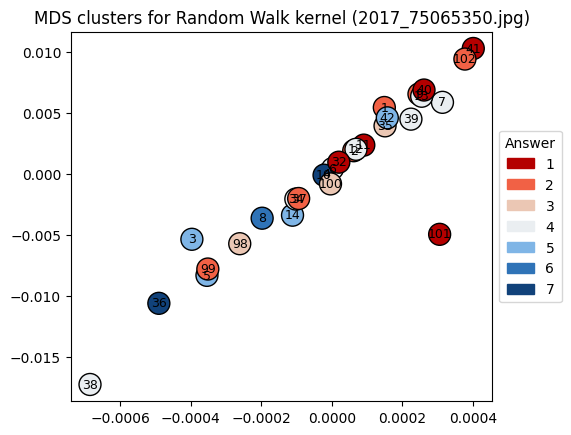

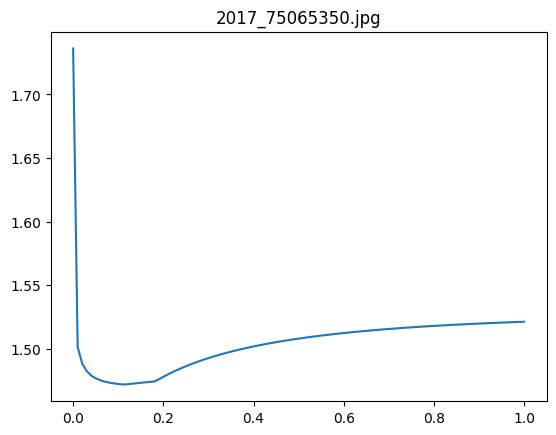

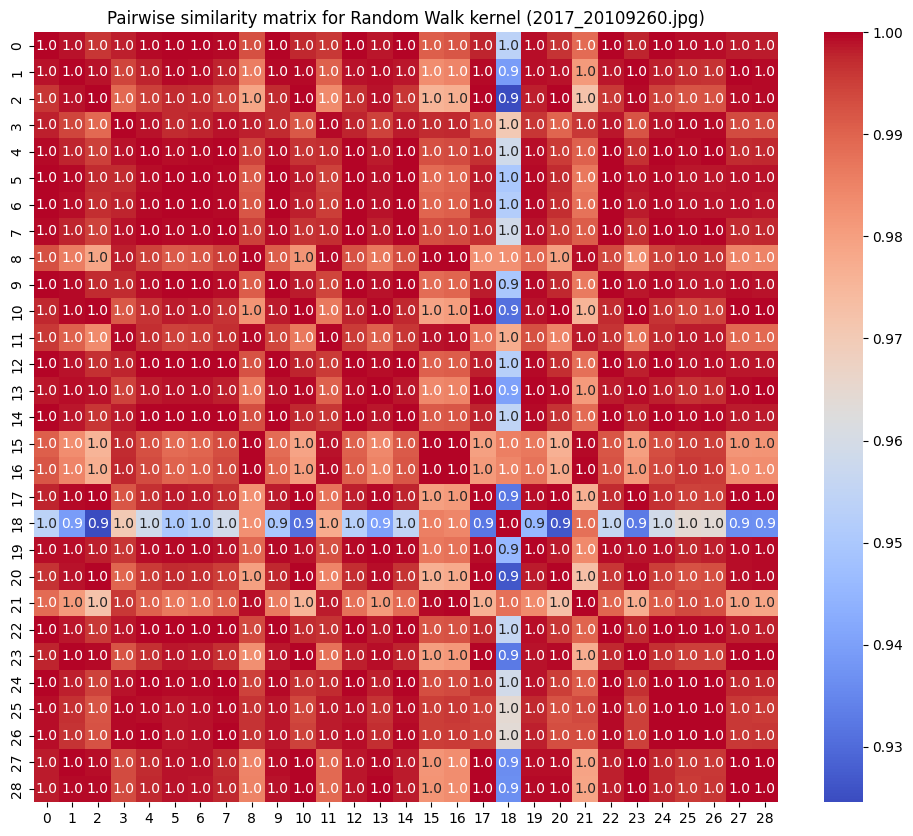

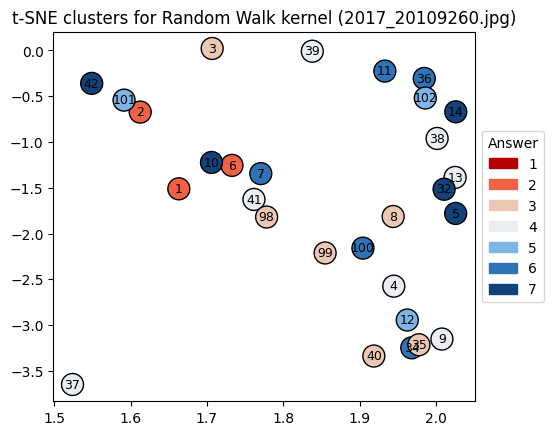

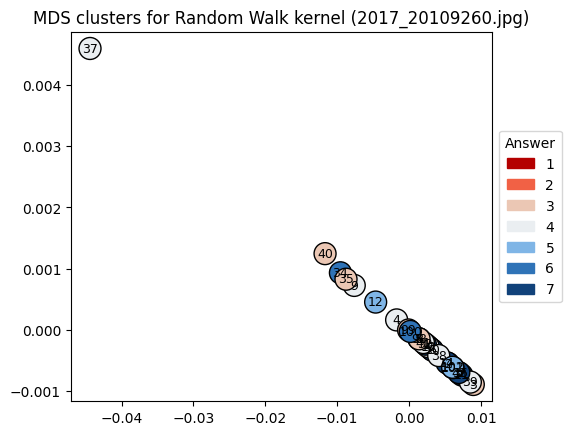

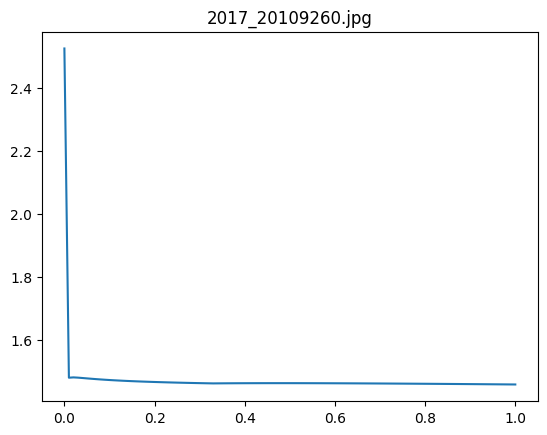

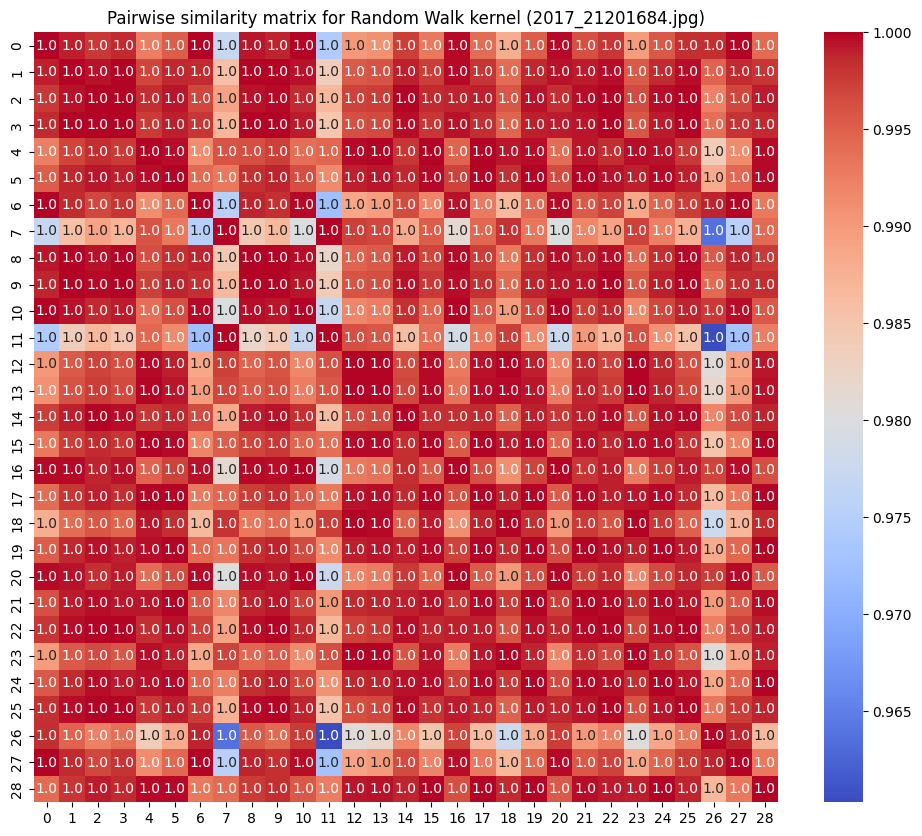

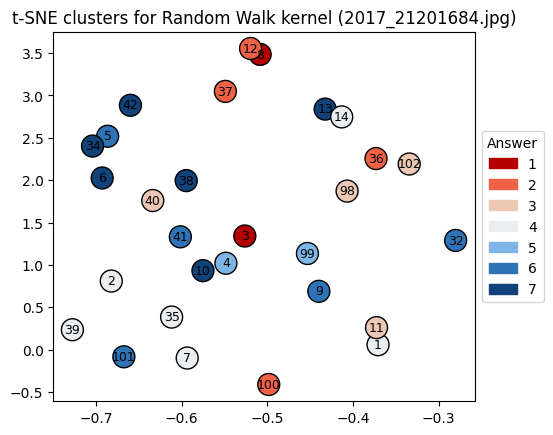

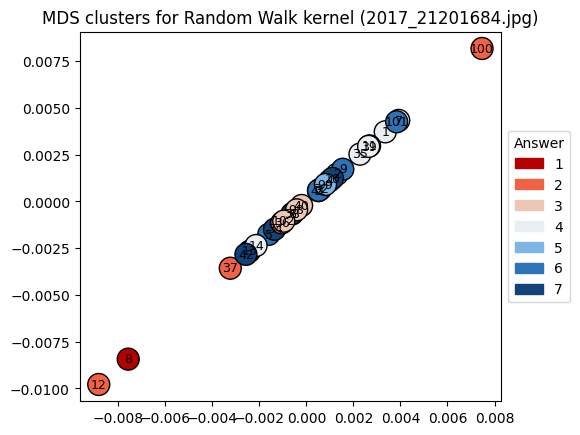

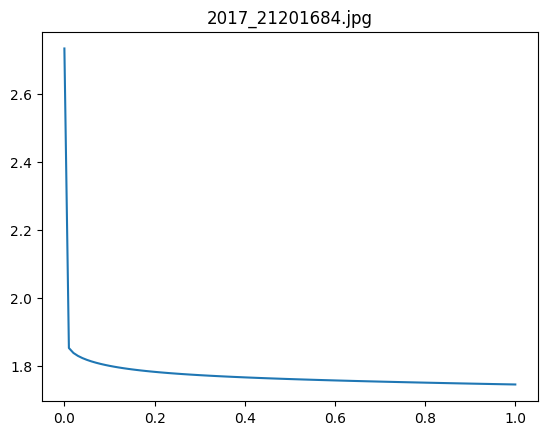

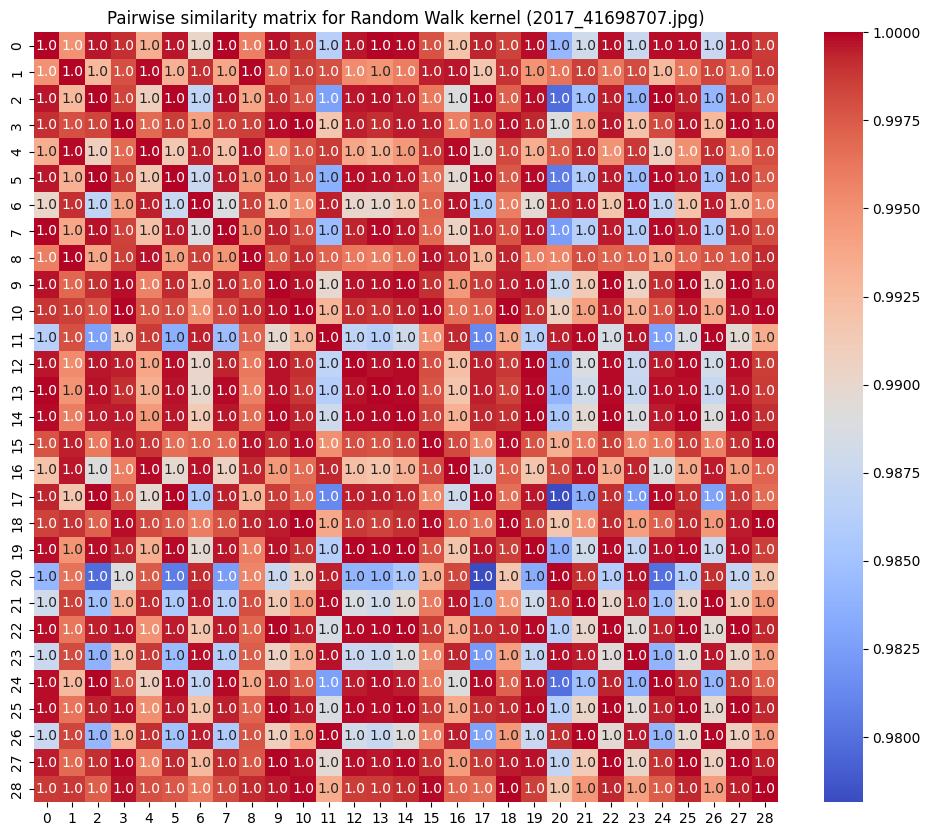

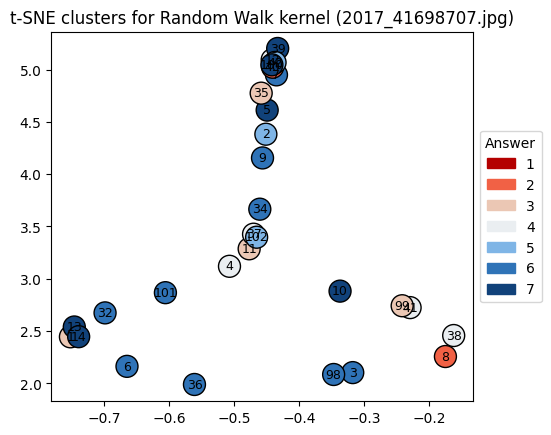

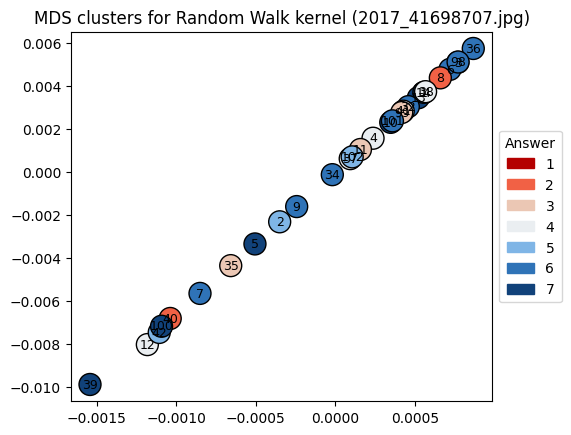

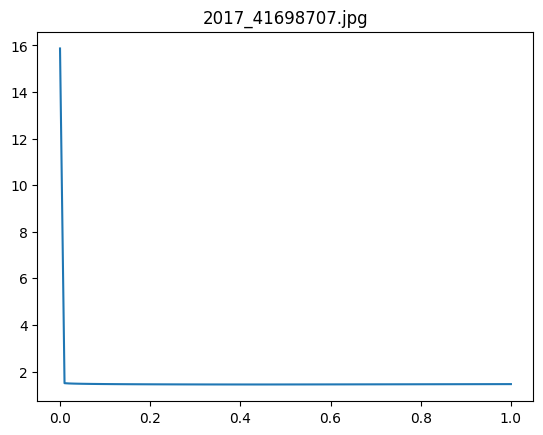

In [4]:
for img in imgs:
    img_file = dl.get_image(img)
    aois = dl.divide_image_aois(img)

    if PLOT["aois"]:
        PlotUtils.plot_aois(aois=aois, title="Original image and predefined AOIs", image=img_file)


    trials = dl.get_image_trials(img)
    trial_numbers = dl.get_image_trials(img, False)
    answer_dfs = dl.get_image_answers(img)
    answers = dl.get_image_ratings(img) # {subject: answer_dfs[subject].query(f"trial == {trial_numbers[subject]}")["response"].item() for subject in trials.keys()}
    if PLOT["scanpaths"]:
        PlotUtils.wrap_dict_plot(trials, n_wrap=3, plotting_function=PlotUtils.trace_plot, title="Subject", image=img_file)



    # MATCHING TO NEAREST AOI 

    trials_clustered = {subject: GraphUtils.cluster_to_aois(trial, aois) for (subject, trial) in trials.items()}

    if PLOT["clustering"]:
        PlotUtils.wrap_dict_plot(trials_clustered, n_wrap=3, plotting_function=PlotUtils.clustering_plot, title="Subject", image=img_file)



    # TRANSITION MATRCIES
    matrices = {subject: GraphUtils.transition_matrix(trial, aois=aois) for (subject, trial) in trials_clustered.items()}
    if PLOT["matrices"]:
        PlotUtils.wrap_dict_plot(matrices, n_wrap=3, plotting_function=PlotUtils.heatmap, title="Subject")



    # GRAPHS
    graphs = {subject: GraphUtils.transition_matrix_to_graph(matrix) for (subject, matrix) in matrices.items()}
    if PLOT["graphs"]:
        PlotUtils.wrap_dict_plot(graphs, n_wrap=3, plotting_function=PlotUtils.draw, title="Subject")



    # PRECOMPUTED KERNEL MATRIX
    subjects_order = list(matrices.keys())
    K_matrix = np.zeros(shape=(len(matrices), len(matrices)))
    for i, (subject1, matrix1) in enumerate(matrices.items()):
        for j, (subject2, matrix2) in enumerate(matrices.items()):
            K = RandomWalkKernel.weighted_random_walk_kernel(matrix1, matrix2, decay=0.5, normalize=True)
            K_matrix[i][j] = K

    if PLOT["kernel"]:
        PlotUtils.heatmap(K_matrix, title=f"Pairwise similarity matrix for Random Walk kernel ({img})")


    D_matrix = 1 - K_matrix

    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    X_2d_mds = mds.fit_transform(D_matrix)

    tsne = TSNE(n_components=2, perplexity=20, metric='precomputed', init="random", random_state=42)
    X_2d_tsne = tsne.fit_transform(D_matrix)

    labels = np.array(list(answers.values()))

    if PLOT["tsne"]:
        PlotUtils.dimensionality_reduction_plot(X_2d_tsne, title=f"t-SNE clusters for Random Walk kernel ({img})", annotate=True, labels=answers)
    
    if PLOT["mds"]:
        PlotUtils.dimensionality_reduction_plot(X_2d_mds, title=f"MDS clusters for Random Walk kernel ({img})", annotate=True, labels=answers)


    # LEAVE ONE OUT CROSS VALIDATION
    results = []
    alphas = np.arange(0, 1.01, 0.01)
    for alpha in alphas:
        loocv = LeaveOneOut()
        y_true, y_pred = [], []
        for train_index, test_index in loocv.split(K_matrix):
            K_train = K_matrix[np.ix_(train_index, train_index)]
            K_test = K_matrix[np.ix_(test_index, train_index)]
            model = KernelRidge(alpha=alpha, kernel="precomputed")
            model.fit(K_train, labels[train_index])
                        
            y_hat = model.predict(K_test)
            y_true.append(float(labels[test_index][0]))
            y_pred.append(float(y_hat[0]))
            
        mae = mean_absolute_error(y_true, y_pred)
        rmse = root_mean_squared_error(y_true, y_pred)

        y_pred_rounded = np.clip(np.rint(y_pred), 1, 7)
        acc = np.mean(np.array(y_pred_rounded) == np.array(y_true))
        results.append(mae)
    
    fig, ax = plt.subplots(1,1)
    ax.set(title=img)
    ax.plot(alphas, results)
